In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/Exploration/1st_hackathon' 

train_data_path = join(data_dir, 'sales_train.csv') 

# data 읽어보기

sales_train.csv 데이터를 확인해보자

In [3]:
data = pd.read_csv(train_data_path)
print('train data dim : {}'.format(data.shape))

train data dim : (2935849, 6)


In [4]:
print(data.columns)

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')


# item 확인하기

아이템 품명을 확인했더니 러시아 제품임을 알 수 있었다.  
번역을 통해 어떤 물품에 대한 데이터 인지 알면 더 특징적으로 분석할 수 도 있겠지만,  
이번에는 시간 관계상 짚고 넘어가지 않았다.  

In [5]:
# 확인하기
items = pd.read_csv('items.csv')
items.head(10)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


# test 와 data와의 관계들

In [6]:
sample = pd.read_csv('sample_submission.csv')
print(len(sample)) 
sample

214200


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5
...,...,...
214195,214195,0.5
214196,214196,0.5
214197,214197,0.5
214198,214198,0.5


In [7]:
test = pd.read_csv('test.csv')
print(len(test)) # test 개수가 바로 추측해야하는 아이템 개수
test

214200


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


> len(sample) == len(test)  
동일함 확인

In [8]:
test_ndarray = test.values
test_ndarray

array([[     0,      5,   5037],
       [     1,      5,   5320],
       [     2,      5,   5233],
       ...,
       [214197,     45,  15757],
       [214198,     45,  19648],
       [214199,     45,    969]])

In [9]:
test_item_id = test_ndarray[:, 2]
test_item_id

array([ 5037,  5320,  5233, ..., 15757, 19648,   969])

In [10]:
test_item_id_uniq = np.unique(test_item_id)
print(len(test_item_id_uniq))
test_item_id_uniq

5100


array([   30,    31,    32, ..., 22164, 22166, 22167])

In [11]:
data_ndarray = data.values
data_ndarray

array([['02.01.2013', 0, 59, 22154, 999.0, 1.0],
       ['03.01.2013', 0, 25, 2552, 899.0, 1.0],
       ['05.01.2013', 0, 25, 2552, 899.0, -1.0],
       ...,
       ['14.10.2015', 33, 25, 7459, 349.0, 1.0],
       ['22.10.2015', 33, 25, 7440, 299.0, 1.0],
       ['03.10.2015', 33, 25, 7460, 299.0, 1.0]], dtype=object)

In [12]:
# item_id만 array로
data_item_id = data_ndarray[:, 3]
print(len(data_item_id))
data_item_id

2935849


array([22154, 2552, 2552, ..., 7459, 7440, 7460], dtype=object)

In [13]:
item_id_uniq = np.unique(data_item_id)
print(len(item_id_uniq))
item_id_uniq

21807


array([0, 1, 2, ..., 22167, 22168, 22169], dtype=object)

In [14]:
test_only = set(test_item_id_uniq) - set(item_id_uniq)
print(len(test_only))
# test_only

363


위를 통해 2015년에 새롭게 판매되는 제품이 있다는 것을 알게 되었다.  
  
test에만 있고 train에만 있는 것,   
11월 신상품이 363개라고 해석할 수 있다.     
    
어떻게 해야 신상품의 첫 달 판매량을 구할 수 있을까 고민하다가   
10 -> 15년 11월  
21 -> 16년 11월   
신상품의 평균 판매량을 확인하게 되었다.  
이땐 몰랐다. 이걸 알게 되어도 어떻게 써먹어야하는 줄 모르는 줄은 ㅎ 

# 13년 11월 신상품

In [15]:
data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [16]:
num_item_id = data.loc[:, ['date_block_num', 'item_id']]
num_item_id

,date_block_num,item_id
0,0,22154
1,0,2552
2,0,2552
3,0,2554
4,0,2555
...,...,...
2935844,33,7409
2935845,33,7460
2935846,33,7459
2935847,33,7440


## 13년 10월

In [17]:
# 13년 10월
tt_oct = num_item_id[num_item_id['date_block_num'].isin([0,1,2,3,4,5,6,7,8,9])]
tt_oct

,date_block_num,item_id
0,0,22154
1,0,2552
2,0,2552
3,0,2554
4,0,2555
...,...,...
1027575,9,11812
1027576,9,11811
1027577,9,11623
1027578,9,5680


In [18]:
# 13 oct -> array
tt_oct_array = tt_oct.values
tt_oct_array

array([[    0, 22154],
       [    0,  2552],
       [    0,  2552],
       ...,
       [    9, 11623],
       [    9,  5680],
       [    9,  5682]])

In [19]:
# 13 oct array에서 추출 
tt_oct_item = tt_oct_array[:, 1]
print(len(tt_oct_item))
tt_oct_item

1027580


array([22154,  2552,  2552, ..., 11623,  5680,  5682])

In [20]:
# 중복제거
tt_oct_item_uniq = np.unique(tt_oct_item)
print(len(tt_oct_item_uniq))
tt_oct_item_uniq

13946


array([   12,    19,    27, ..., 22166, 22167, 22168])

13년 10월까지 판매된 제품의 종류 개수는 13946개이다. 

## 13년 11월

In [21]:
# 13년 11월
tt_nov = num_item_id[num_item_id['date_block_num'] == 10]
tt_nov

,date_block_num,item_id
1027580,10,4420
1027581,10,10033
1027582,10,10051
1027583,10,10051
1027584,10,10051
...,...,...
1124311,10,3734
1124312,10,3734
1124313,10,3743
1124314,10,3743


In [22]:
# 13 nov -> array
tt_nov_array = tt_nov.values
tt_nov_array

array([[   10,  4420],
       [   10, 10033],
       [   10, 10051],
       ...,
       [   10,  3743],
       [   10,  3743],
       [   10,  3734]])

In [23]:
# 13 nov array에서 추출 
tt_nov_item = tt_nov_array[:, 1]
print(len(tt_nov_item))
tt_nov_item

96736


array([ 4420, 10033, 10051, ...,  3743,  3743,  3734])

In [24]:
# 중복제거
tt_nov_item_uniq = np.unique(tt_nov_item)
print(len(tt_nov_item_uniq))
tt_nov_item_uniq

8089


array([   27,    28,    30, ..., 22155, 22166, 22167])

In [25]:
# tt nov only
tt_nov_only = set(tt_nov_item_uniq) - set(tt_oct_item_uniq)
print('13년 11월 신상품 :', len(tt_nov_only))
print(type(tt_nov_only))
# tt_nov_only

13년 11월 신상품 : 489
<class 'set'>


In [26]:
# set -> list
lst_tt_nov_only = list(tt_nov_only)
# lst_tt_nov_only

## 13년 11월 신상품 얼마인지 dict이나 dataframe으로 그리고 가격

In [27]:
# 13년 11월
tt_nov_new = data[data['item_id'].isin(lst_tt_nov_only)]
tt_nov_new = tt_nov_new[tt_nov_new['date_block_num'] == 10]
tt_nov_new

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1027637,30.11.2013,10,28,10297,749.0,1.0
1027690,30.11.2013,10,28,10299,1399.0,1.0
1027713,21.11.2013,10,28,9077,299.0,1.0
1027714,24.11.2013,10,28,9077,299.0,1.0
1027715,30.11.2013,10,28,9077,299.0,1.0
...,...,...,...,...,...,...
1124068,29.11.2013,10,50,3333,2599.0,8.0
1124125,29.11.2013,10,50,4271,2799.0,7.0
1124196,30.11.2013,10,50,3899,299.0,1.0
1124234,29.11.2013,10,50,4231,2799.0,25.0


In [28]:
len(tt_nov_item) - len(tt_nov_new)

82976

82976개는 기존에도 팔던거,  
13760개는 11월 신상품

In [29]:
print(tt_nov_new['item_price'].describe())

count    13760.000000
mean      1128.557608
std       1693.105961
min         22.400000
25%        399.000000
50%        699.000000
75%       1399.000000
max      18665.000000
Name: item_price, dtype: float64


13년 11월 신상품의 가격 평균은 1128.56 이다.

# 14년 11월 신상품

## 14년 10월까지 팔렸던 상품들

In [30]:
# 14년 10월까지
ft_oct = num_item_id[num_item_id['date_block_num'].isin([0,1,2,3,4,5,6,7,8,9,10,11,
                                                         12,13,14,15,16,17,18,19,20,21])]
ft_oct

,date_block_num,item_id
0,0,22154
1,0,2552
2,0,2552
3,0,2554
4,0,2555
...,...,...
2106204,21,7351
2106205,21,7492
2106206,21,7215
2106207,21,12596


In [31]:
# 14 oct -> array
ft_oct_array = ft_oct.values
ft_oct_array

array([[    0, 22154],
       [    0,  2552],
       [    0,  2552],
       ...,
       [   21,  7215],
       [   21, 12596],
       [   21, 18335]])

In [32]:
# 14 oct array에서 추출 
ft_oct_item = ft_oct_array[:, 1]
print(len(ft_oct_item))
ft_oct_item

2106209


array([22154,  2552,  2552, ...,  7215, 12596, 18335])

In [33]:
# 중복제거
ft_oct_item_uniq = np.unique(ft_oct_item)
print(len(ft_oct_item_uniq))
ft_oct_item_uniq

18115


array([    0,     1,     2, ..., 22167, 22168, 22169])

13년 1월부터 14년 10월까지 팔린 상품 종류 개수는 18115개

## 14년 11월 신상품

In [34]:
# 14년 11월
ft_nov = num_item_id[num_item_id['date_block_num'] == 22]
ft_nov

,date_block_num,item_id
2106209,22,3460
2106210,22,4615
2106211,22,4870
2106212,22,4870
2106213,22,4870
...,...,...
2192632,22,59
2192633,22,59
2192634,22,77
2192635,22,32


In [35]:
# 14 nov -> array
ft_nov_array = ft_nov.values
ft_nov_array

array([[  22, 3460],
       [  22, 4615],
       [  22, 4870],
       ...,
       [  22,   77],
       [  22,   32],
       [  22,   32]])

In [36]:
# 14 nov array에서 추출 
ft_nov_item = ft_nov_array[:, 1]
print(len(ft_nov_item))
ft_nov_item

86428


array([3460, 4615, 4870, ...,   77,   32,   32])

In [37]:
# 중복제거
ft_nov_item_uniq = np.unique(ft_nov_item)
print(len(ft_nov_item_uniq))
ft_nov_item_uniq

6322


array([    2,    11,    15, ..., 22146, 22166, 22167])

In [38]:
# ft nov only
ft_nov_only = set(ft_nov_item_uniq) - set(ft_oct_item_uniq)
print('14년 11월 신상품 :', len(ft_nov_only))
print(type(ft_nov_only))
# ft_nov_only

14년 11월 신상품 : 460
<class 'set'>


In [39]:
# list로 만들기 
lst_ft_nov_only = list(ft_nov_only)
# lst_ft_nov_only

## 14년 11월 신상품 얼마인지 dict이나 dataframe으로 그리고 가격

In [40]:
# 14년 11월
ft_nov_new = data[data['item_id'].isin(lst_ft_nov_only)]
ft_nov_new = ft_nov_new[ft_nov_new['date_block_num'] == 22]
ft_nov_new

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2106209,19.11.2014,22,37,3460,1299.0,3.0
2106256,21.11.2014,22,33,4334,799.0,1.0
2106257,28.11.2014,22,33,4334,799.0,1.0
2106259,23.11.2014,22,33,4337,2999.0,1.0
2106270,26.11.2014,22,33,4478,2499.0,1.0
...,...,...,...,...,...,...
2192494,21.11.2014,22,46,21387,1529.0,1.0
2192495,20.11.2014,22,46,21387,1444.0,2.0
2192498,21.11.2014,22,46,21430,799.0,1.0
2192500,28.11.2014,22,46,21976,1349.0,1.0


In [41]:
len(ft_nov_item) - len(ft_nov_new)

70784

70784 기존 제품 판매량  
15644 신상품 460개에 대한 판매량

In [42]:
print(ft_nov_new['item_price'].describe())

count    15644.000000
mean      2096.400350
std       2606.630176
min         10.000000
25%        699.000000
50%       1619.000000
75%       2999.000000
max      40900.000000
Name: item_price, dtype: float64


In [43]:
print(ft_nov_new['item_price'].describe())

count    15644.000000
mean      2096.400350
std       2606.630176
min         10.000000
25%        699.000000
50%       1619.000000
75%       2999.000000
max      40900.000000
Name: item_price, dtype: float64


각 년도의 11월 신상품에 대한 평균 가격 차이가 많이 난다.

# 신상품에 대한 평균적 판매량

In [44]:
print(tt_nov_new['item_cnt_day'].describe())

count    13760.000000
mean         2.039026
std          3.889715
min         -2.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        126.000000
Name: item_cnt_day, dtype: float64


In [45]:
print(ft_nov_new['item_cnt_day'].describe())

count    15644.000000
mean         2.006328
std          4.250637
min         -1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        167.000000
Name: item_cnt_day, dtype: float64


다행히 판매량의 평균은 2개로 동일   
하지만 이렇게 신상품의 평균 판매 개수를 학습단계에서 어떻게 적용하는지 몰랐다.  
부분적으로 학습시키는 모델에 대해 더 공부가 필요함을 느꼈다.

# 34개월 동안 판매량 describe

In [46]:
print(data['item_cnt_day'].describe())

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64


아이템 별 판매 수량이 -22 부터 2169가 팔린것을 확인 할 수 있다.   
음수인 data를 어떻게 처리할까하다가 다른 조원과 이야기하면서 반품일 수도 있다는 의견을 수용해서  
따로 전처리하지 않고 그대로 사용했다.  

# 어떤 아이템이 제일 많이 팔렸는지 궁금해

In [47]:
# dataframe -> ndarray
data_ndarray = data.values
data_ndarray

array([['02.01.2013', 0, 59, 22154, 999.0, 1.0],
       ['03.01.2013', 0, 25, 2552, 899.0, 1.0],
       ['05.01.2013', 0, 25, 2552, 899.0, -1.0],
       ...,
       ['14.10.2015', 33, 25, 7459, 349.0, 1.0],
       ['22.10.2015', 33, 25, 7440, 299.0, 1.0],
       ['03.10.2015', 33, 25, 7460, 299.0, 1.0]], dtype=object)

In [48]:
org_data = data
del data['date']
del data['date_block_num']
del data['shop_id']
del data['item_cnt_day']

id_and_price = data

In [49]:
id_and_price.head()

,item_id,item_price
0,22154,999.00
1,2552,899.00
2,2552,899.00
3,2554,1709.05
4,2555,1099.00


In [50]:
print(id_and_price.groupby(data['item_id']).count().sort_values(['item_price'], ascending=False))

         item_price
item_id            
20949         31340
5822           9408
17717          9067
2808           7479
4181           6853
...             ...
10752             1
10753             1
10799             1
10835             1
22169             1

[21807 rows x 1 columns]


\#20949가 압도적으로 많이 팔렸다.

# 각 년도별 판매 추이 
- 사실 2015년은 메르스가 유행했던 시절이다. 러시아 사람들이 공공보건을 잘 지켰을 지는 모르겠지만 판매품들은 대부분 소프트웨어와 하드웨어와 관련된 제품들이다. 이에 **년도와 판매 추이의 관련성**이 존재하는지 증명하려고 한다. 

## 13년도

In [51]:
data = pd.read_csv(train_data_path)
num_item_cnt = data.loc[:, ['date_block_num', 'item_id', 'item_cnt_day']]
num_item_cnt

,date_block_num,item_id,item_cnt_day
0,0,22154,1.0
1,0,2552,1.0
2,0,2552,-1.0
3,0,2554,1.0
4,0,2555,1.0
...,...,...,...
2935844,33,7409,1.0
2935845,33,7460,1.0
2935846,33,7459,1.0
2935847,33,7440,1.0


In [52]:
# 13_jan
tt_cnt_jan = num_item_cnt[num_item_cnt['date_block_num'].isin([0])]
num_item_cnt_jan = tt_cnt_jan['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
num_item_cnt_jan

131479.0

In [53]:
# 13_feb
tt_cnt_feb = num_item_cnt[num_item_cnt['date_block_num'].isin([1])]
num_item_cnt_feb = tt_cnt_feb['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
num_item_cnt_feb

128090.0

In [54]:
# 13_mar
tt_cnt_mar = num_item_cnt[num_item_cnt['date_block_num'].isin([2])]
num_item_cnt_mar = tt_cnt_mar['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
num_item_cnt_mar

147142.0

In [55]:
# 13_apr
tt_cnt_apr = num_item_cnt[num_item_cnt['date_block_num'].isin([3])]
num_item_cnt_apr = tt_cnt_apr['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
num_item_cnt_apr

107190.0

In [56]:
# 13_may
tt_cnt_may = num_item_cnt[num_item_cnt['date_block_num'].isin([4])]
num_item_cnt_may = tt_cnt_may['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
num_item_cnt_may

106970.0

In [57]:
# 13_jun
tt_cnt_jun = num_item_cnt[num_item_cnt['date_block_num'].isin([5])]
num_item_cnt_jun = tt_cnt_jun['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
num_item_cnt_jun

125381.0

In [58]:
# 13_jul
tt_cnt_jul = num_item_cnt[num_item_cnt['date_block_num'].isin([6])]
num_item_cnt_jul = tt_cnt_jul['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
num_item_cnt_jul

116966.0

In [59]:
# 13_aug
tt_cnt_aug = num_item_cnt[num_item_cnt['date_block_num'].isin([7])]
num_item_cnt_aug = tt_cnt_aug['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
num_item_cnt_aug

125291.0

In [60]:
# 13_sep
tt_cnt_sep = num_item_cnt[num_item_cnt['date_block_num'].isin([8])]
num_item_cnt_sep = tt_cnt_sep['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
num_item_cnt_sep

133332.0

In [61]:
# 13_oct
tt_cnt_oct = num_item_cnt[num_item_cnt['date_block_num'].isin([9])]
num_item_cnt_oct = tt_cnt_oct['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
num_item_cnt_oct

127541.0

In [62]:
# 13_nov
tt_cnt_nov = num_item_cnt[num_item_cnt['date_block_num'].isin([10])]
num_item_cnt_nov = tt_cnt_nov['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
num_item_cnt_nov

130009.0

In [63]:
# 13_dec
tt_cnt_dec = num_item_cnt[num_item_cnt['date_block_num'].isin([11])]
num_item_cnt_dec = tt_cnt_dec['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
num_item_cnt_dec

183342.0

In [64]:
cnt_per_month = (num_item_cnt_jan,
                     num_item_cnt_feb,
                     num_item_cnt_mar,
                     num_item_cnt_apr,
                     num_item_cnt_may,
                     num_item_cnt_jun,
                     num_item_cnt_jul,
                     num_item_cnt_aug,
                     num_item_cnt_sep,
                     num_item_cnt_oct,
                     num_item_cnt_nov,
                     num_item_cnt_dec)

In [65]:
type(cnt_per_month)

tuple

In [66]:
cnt_per_month = list(cnt_per_month)
type(cnt_per_month)

list

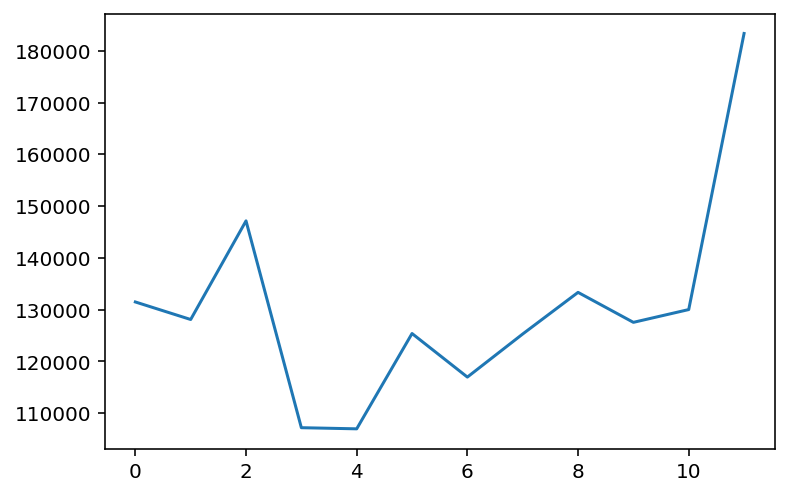

In [67]:
plt.plot(cnt_per_month)
plt.show()

## 14년도

In [68]:
# 14_jan
ft_cnt_jan = num_item_cnt[num_item_cnt['date_block_num'].isin([12])]
ft_num_item_cnt_jan = ft_cnt_jan['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
ft_num_item_cnt_jan

116899.0

In [69]:
# 14_feb
ft_cnt_feb = num_item_cnt[num_item_cnt['date_block_num'].isin([13])]
ft_num_item_cnt_feb = ft_cnt_feb['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
ft_num_item_cnt_feb

109687.0

In [70]:
# 14_mar
ft_cnt_mar = num_item_cnt[num_item_cnt['date_block_num'].isin([14])]
ft_num_item_cnt_mar = ft_cnt_mar['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
ft_num_item_cnt_mar

115297.0

In [71]:
# 14_apr
ft_cnt_apr = num_item_cnt[num_item_cnt['date_block_num'].isin([15])]
ft_num_item_cnt_apr = ft_cnt_apr['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
ft_num_item_cnt_apr

96556.0

In [72]:
# 14_may
ft_cnt_may = num_item_cnt[num_item_cnt['date_block_num'].isin([16])]
ft_num_item_cnt_may = ft_cnt_may['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
ft_num_item_cnt_may

97790.0

In [73]:
# 14_jun
ft_cnt_jun = num_item_cnt[num_item_cnt['date_block_num'].isin([17])]
ft_num_item_cnt_jun = ft_cnt_jun['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
ft_num_item_cnt_jun

97429.0

In [74]:
# 14_jul
ft_cnt_jul = num_item_cnt[num_item_cnt['date_block_num'].isin([18])]
ft_num_item_cnt_jul = ft_cnt_jul['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
ft_num_item_cnt_jul

91280.0

In [75]:
# 14_aug
ft_cnt_aug = num_item_cnt[num_item_cnt['date_block_num'].isin([19])]
ft_num_item_cnt_aug = ft_cnt_aug['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
ft_num_item_cnt_aug

102721.0

In [76]:
# 14_sep
ft_cnt_sep = num_item_cnt[num_item_cnt['date_block_num'].isin([20])]
ft_num_item_cnt_sep = ft_cnt_sep['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
ft_num_item_cnt_sep

99208.0

In [77]:
# 14_oct
ft_cnt_oct = num_item_cnt[num_item_cnt['date_block_num'].isin([21])]
ft_num_item_cnt_oct = ft_cnt_oct['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
ft_num_item_cnt_oct

107422.0

In [78]:
# 14_nov
ft_cnt_nov = num_item_cnt[num_item_cnt['date_block_num'].isin([22])]
ft_num_item_cnt_nov = ft_cnt_nov['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
ft_num_item_cnt_nov

117845.0

In [79]:
# 14_dec
ft_cnt_dec = num_item_cnt[num_item_cnt['date_block_num'].isin([23])]
ft_num_item_cnt_dec = ft_cnt_dec['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
ft_num_item_cnt_dec

168755.0

In [80]:
ft_cnt_per_month = (ft_num_item_cnt_jan,
                     ft_num_item_cnt_feb,
                     ft_num_item_cnt_mar,
                     ft_num_item_cnt_apr,
                     ft_num_item_cnt_may,
                     ft_num_item_cnt_jun,
                     ft_num_item_cnt_jul,
                     ft_num_item_cnt_aug,
                     ft_num_item_cnt_sep,
                     ft_num_item_cnt_oct,
                     ft_num_item_cnt_nov,
                     ft_num_item_cnt_dec)

In [81]:
type(ft_cnt_per_month)

tuple

In [82]:
ft_cnt_per_month = list(ft_cnt_per_month)
type(ft_cnt_per_month)

list

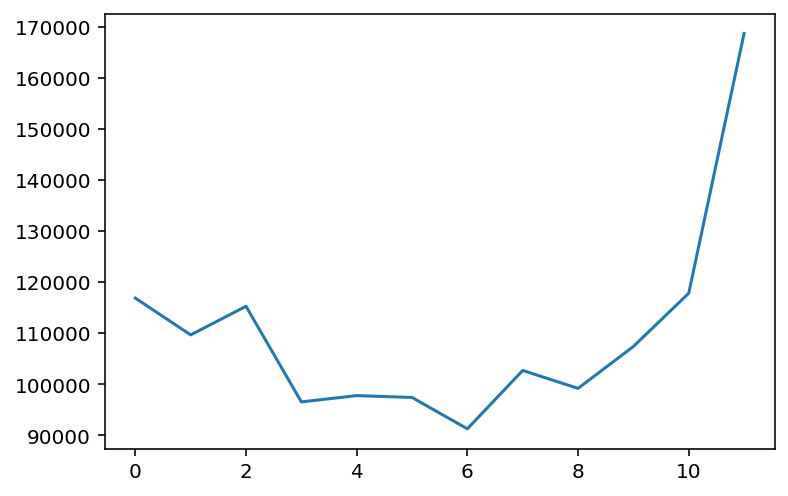

In [83]:
plt.plot(ft_cnt_per_month)
plt.show()

## 15년도

In [84]:
# 15_jan
fft_cnt_jan = num_item_cnt[num_item_cnt['date_block_num'].isin([24])]
fft_num_item_cnt_jan = fft_cnt_jan['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
fft_num_item_cnt_jan

110971.0

In [85]:
# 15_feb
fft_cnt_feb = num_item_cnt[num_item_cnt['date_block_num'].isin([25])]
fft_num_item_cnt_feb = fft_cnt_feb['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
fft_num_item_cnt_feb

84198.0

In [86]:
# 15_mar
fft_cnt_mar = num_item_cnt[num_item_cnt['date_block_num'].isin([26])]
fft_num_item_cnt_mar = fft_cnt_mar['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
fft_num_item_cnt_mar

82014.0

In [87]:
# 15_apr
fft_cnt_apr = num_item_cnt[num_item_cnt['date_block_num'].isin([27])]
fft_num_item_cnt_apr = fft_cnt_apr['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
fft_num_item_cnt_apr

77827.0

In [88]:
# 15_may
fft_cnt_may = num_item_cnt[num_item_cnt['date_block_num'].isin([28])]
fft_num_item_cnt_may = fft_cnt_may['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
fft_num_item_cnt_may

72295.0

In [89]:
# 15_jun
fft_cnt_jun = num_item_cnt[num_item_cnt['date_block_num'].isin([29])]
fft_num_item_cnt_jun = fft_cnt_jun['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
fft_num_item_cnt_jun

64114.0

In [90]:
# 15_jul
fft_cnt_jul = num_item_cnt[num_item_cnt['date_block_num'].isin([30])]
fft_num_item_cnt_jul = fft_cnt_jul['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
fft_num_item_cnt_jul

63187.0

In [91]:
# 15_aug
fft_cnt_aug = num_item_cnt[num_item_cnt['date_block_num'].isin([31])]
fft_num_item_cnt_aug = fft_cnt_aug['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
fft_num_item_cnt_aug

66079.0

In [92]:
# 15_sep
fft_cnt_sep = num_item_cnt[num_item_cnt['date_block_num'].isin([32])]
fft_num_item_cnt_sep = fft_cnt_sep['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
fft_num_item_cnt_sep

72843.0

In [93]:
# 15_oct
fft_cnt_oct = num_item_cnt[num_item_cnt['date_block_num'].isin([33])]
fft_num_item_cnt_oct = fft_cnt_oct['item_cnt_day'].sum(axis=0) # axis=0 -> 세로합
fft_num_item_cnt_oct

71056.0

In [94]:
fft_cnt_per_month = (fft_num_item_cnt_jan,
                     fft_num_item_cnt_feb,
                     fft_num_item_cnt_mar,
                     fft_num_item_cnt_apr,
                     fft_num_item_cnt_may,
                     fft_num_item_cnt_jun,
                     fft_num_item_cnt_jul,
                     fft_num_item_cnt_aug,
                     fft_num_item_cnt_sep,
                     fft_num_item_cnt_oct)

In [95]:
type(fft_cnt_per_month)

tuple

In [96]:
fft_cnt_per_month = list(fft_cnt_per_month)
type(fft_cnt_per_month)

list

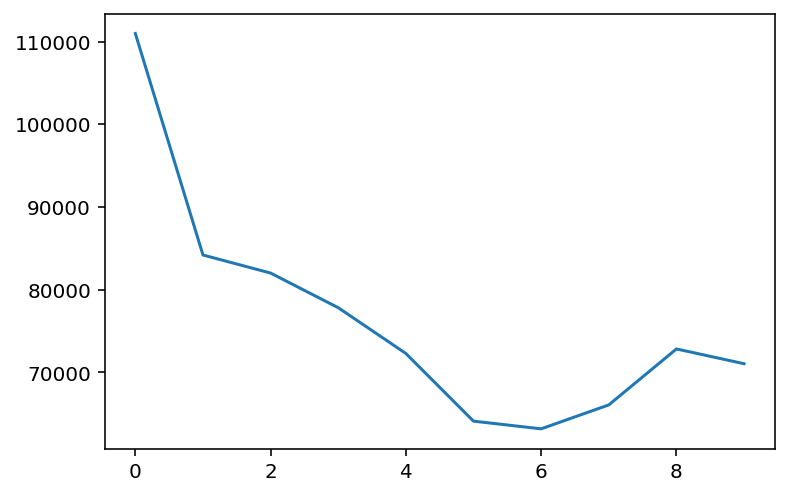

In [97]:
plt.plot(fft_cnt_per_month)
plt.show()

## 모음

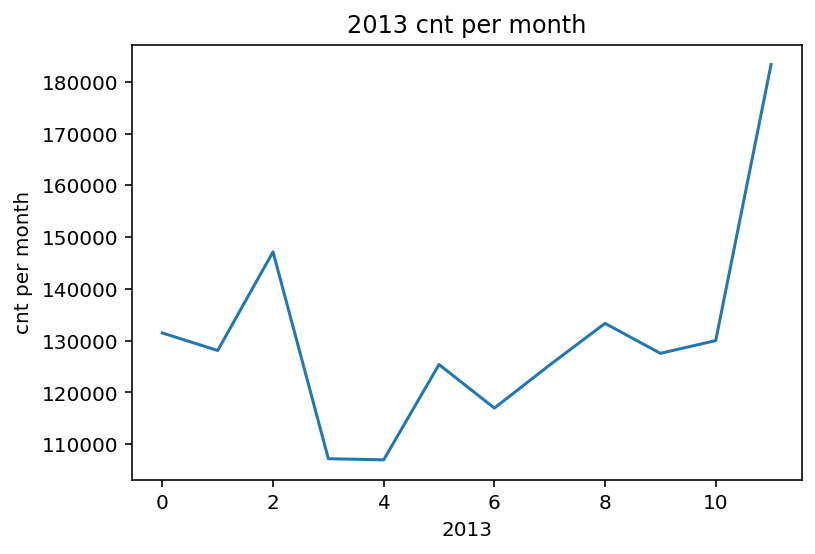

In [98]:
plt.plot(cnt_per_month)
plt.xlabel('2013')
plt.ylabel('cnt per month')
plt.title('2013 cnt per month')
plt.show()

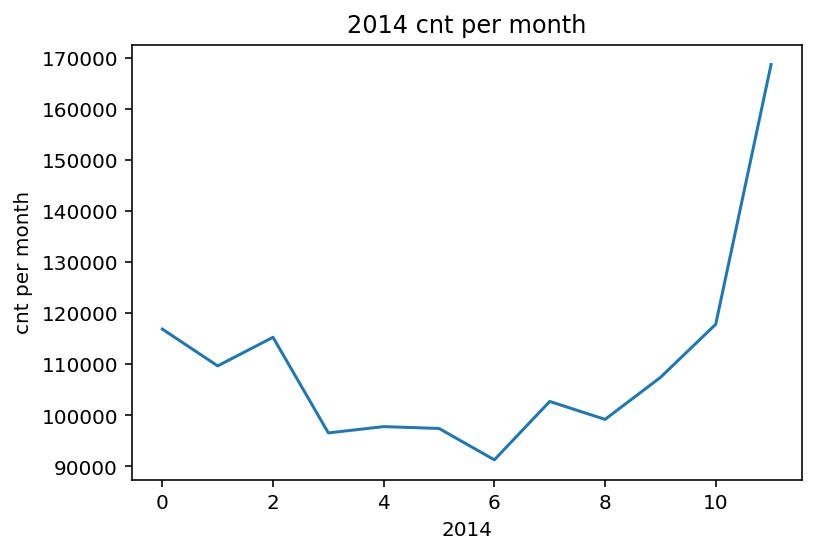

In [99]:
plt.plot(ft_cnt_per_month)
plt.xlabel('2014')
plt.ylabel('cnt per month')
plt.title('2014 cnt per month')
plt.show()

13년도의 월판매량과 14년도의 월판매량이 아주 비슷한 그래프를 보였다. 특히 12월에 판매량이 급증했기 때문에 이를 이상치를 두기로했다.  
이상치의 첫번째 방법은 12월 data를 모두 무시하는 것이었고,  
두번째는 12월과 1월에 sale 날짜를 세심하게 제외하는 것이다.  

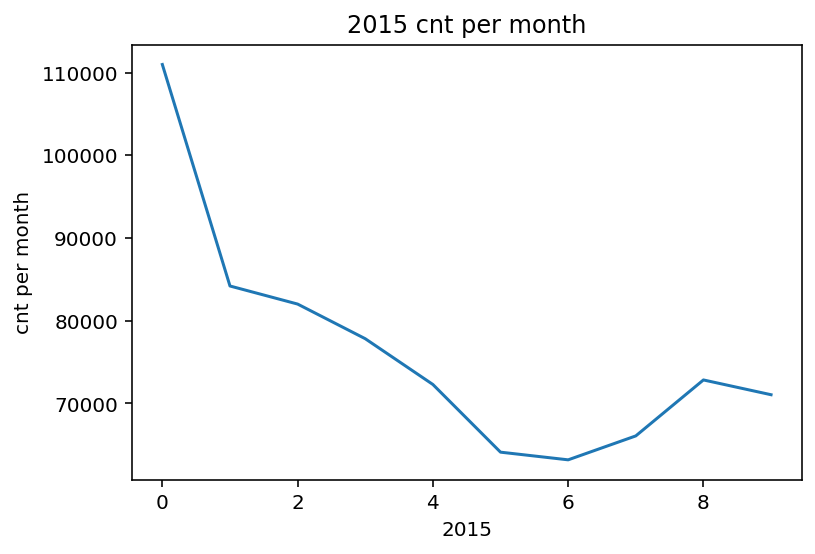

In [100]:
plt.plot(fft_cnt_per_month)
plt.xlabel('2015')
plt.ylabel('cnt per month')
plt.title('2015 cnt per month')
plt.show()

# baseline model

In [101]:
y = data['item_cnt_day']

del data['item_cnt_day']

print(data.columns)

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price'], dtype='object')


In [102]:
del data['date']

print(data.columns)

Index(['date_block_num', 'shop_id', 'item_id', 'item_price'], dtype='object')


##  Average Blending
우리는 이번에 회귀 문제를 풀고 있으므로, 위 분류기의 앙상블처럼 투표로 정하는 대신 예측 결과를 평균 내어 활용할 예정입니다.  
여러 가지 모델의 결과를 산술평균하여 블렌딩 모델을 만들겠습니다.
모델은 부스팅 계열인 gboost, xgboost, lightgbm 세 가지를 사용합니다.

In [103]:
gboost = GradientBoostingRegressor(random_state=2021)
xgboost = xgb.XGBRegressor(random_state=2021)
lightgbm = lgb.LGBMRegressor(random_state=2021)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


In [106]:
models = [{'model':lightgbm, 'name':'LightGBM'}]

## Cross Validation  
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [107]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2021).get_n_splits(data.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], 
                                                  np.mean(cross_val_score(m['model'],  #  R^2점수를 반환
                                                                          data.values, 
                                                                          y)), 
                                                  kf=kfold))
print('얍💢')

얍💢


In [108]:
get_cv_score(models)

Model LightGBM CV score : 0.0560


## Make Submission File
cross_val_score() 함수는 회귀모델을 전달할 경우 R^2점수를 반환합니다.  
다음과 같이 여러 모델을 입력하면 각 모델에 대한 예측 결과를 평균 내어 주는 AgeragingBlending() 함수를 만들어 사용합니다.  AgeragingBlending() 함수는 models 딕셔너리 안에 있는 모델을 모두 x와 y로 학습시킨 뒤 predictions에 그 예측 결괏값을 모아서 평균한 값을 반환합니다.  

In [109]:
def AveragingBlending(models, data, y, sub_x):
    for m in models : 
        m['model'].fit(data.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

함수를 활용해서 예측값을 생성

In [110]:
test_data_path = join(data_dir, 'test.csv')
sub = pd.read_csv(test_data_path)

data = pd.read_csv(train_data_path) 
del data['date']
del data['item_cnt_day']
del data['date_block_num']

data_models = data
data_models

,shop_id,item_id,item_price
0,59,22154,999.00
1,25,2552,899.00
2,25,2552,899.00
3,25,2554,1709.05
4,25,2555,1099.00
...,...,...,...
2935844,25,7409,299.00
2935845,25,7460,299.00
2935846,25,7459,349.00
2935847,25,7440,299.00


In [111]:
y_pred = AveragingBlending(models, data_models, y, sub)
print(len(y_pred))
y_pred

214200


array([1.04777584, 1.02315981, 1.02315981, ..., 1.14722235, 1.22082714,
       1.12374012])

In [112]:
print(data.columns)
print(test.columns)

Index(['shop_id', 'item_id', 'item_price'], dtype='object')
Index(['ID', 'shop_id', 'item_id'], dtype='object')


## 캐글에 제출

In [113]:
data_dir = os.getenv('HOME')+'/aiffel/Exploration/1st_hackathon'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [114]:
result = pd.DataFrame({'ID' : submission['ID'], 'item_cnt_month' : y_pred})

result.head()

,ID,item_cnt_month
0,0,1.047776
1,1,1.023160
2,2,1.023160
3,3,1.023160
4,4,1.023160


In [115]:
my_submission_path = join(data_dir, 'submission_lightGBM.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/home/aiffel-dj35/aiffel/Exploration/1st_hackathon/submission_lightGBM.csv


kaggle score : 2.14473  
특별한 전처리 없이 3개의 모델을 적절히 섞어서 진행했을 때의 score이다.  


# 이상치 12월 데이터 모두를 지우고

In [117]:
print(data.columns)

Index(['shop_id', 'item_id', 'item_price'], dtype='object')


In [118]:
# 12월을 제외한 data
data = pd.read_csv(train_data_path)
except_data = data[data['date_block_num'].isin([0,1,2,3,4,5,6,7,8,9,10,
                                          12,13,14,15,16,17,18,19,20,21,22,
                                          24,25,26,27,28,29,30,31,32,33])]
except_data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [119]:
y = except_data['item_cnt_day']

In [120]:
del except_data['item_cnt_day'] 
del except_data['date']

print(except_data.columns)

Index(['date_block_num', 'shop_id', 'item_id', 'item_price'], dtype='object')


##  Average Blending & Cross Validation & Make Submission File

In [121]:
def except_get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2021).get_n_splits(except_data.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], 
                                                  np.mean(cross_val_score(m['model'],  #  R^2점수를 반환
                                                                          except_data.values, 
                                                                          y)), 
                                                  kf=kfold))
print('얍💢')

얍💢


In [123]:
models = [{'model':lightgbm, 'name':'LightGBM'}]

In [124]:
except_get_cv_score(models)

Model LightGBM CV score : -0.1344


In [125]:
test_data_path = join(data_dir, 'test.csv')
sub = pd.read_csv(test_data_path)

del except_data['date_block_num']

except_data_models = except_data
except_data_models

,shop_id,item_id,item_price
0,59,22154,999.00
1,25,2552,899.00
2,25,2552,899.00
3,25,2554,1709.05
4,25,2555,1099.00
...,...,...,...
2935844,25,7409,299.00
2935845,25,7460,299.00
2935846,25,7459,349.00
2935847,25,7440,299.00


In [126]:
except_y_pred = AveragingBlending(models, except_data_models, y, sub)
print(len(except_y_pred))
except_y_pred

214200


array([1.01114329, 0.97452104, 0.97452104, ..., 0.98577829, 1.01763632,
       1.08737327])

## 캐글에 제출

In [127]:
data_dir = os.getenv('HOME')+'/aiffel/Exploration/1st_hackathon'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [128]:
result = pd.DataFrame({'ID' : submission['ID'], 'item_cnt_month' : except_y_pred})

result.head()

,ID,item_cnt_month
0,0,1.011143
1,1,0.974521
2,2,0.974521
3,3,0.974521
4,4,0.974521


In [129]:
except_submission_path = join(data_dir, 'except_submission.csv')
result.to_csv(except_submission_path, index=False)

print(except_submission_path)

/home/aiffel-dj35/aiffel/Exploration/1st_hackathon/except_submission.csv


kaggle score : 2.36042  
이상치가 많은 12월 데이터를 모두 지웠더니 오히려 이상치가 올라갔다.  
그래서 꼼꼼하게 세일기간의 data만 지우고 다시 시도했다.  

# 세일 기간 데이터 지우고 & only lightGBM

In [130]:
data = pd.read_csv(train_data_path)
data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [137]:
data['date'] = pd.to_datetime(data["date"])
data = data.sort_values(by = ['date'])
data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
109593,2013-01-01,0,46,18616,349.0,1.0
85162,2013-01-01,0,54,11854,199.0,1.0
18128,2013-01-01,0,28,4906,1799.0,1.0
112216,2013-01-01,0,42,2931,99.0,1.0
85141,2013-01-01,0,54,11604,349.0,1.0
...,...,...,...,...,...,...
2915898,2015-12-10,33,6,7390,349.0,1.0
2915896,2015-12-10,33,6,7350,349.0,1.0
2922604,2015-12-10,33,28,10304,199.0,1.0
2915871,2015-12-10,33,6,6798,1849.0,1.0


In [138]:
# 세일 기간만 자르기 
data['date'] = pd.to_datetime(data["date"])
data = data.sort_values(by = ['date'])


from datetime import datetime, timedelta

year_end_start1 = datetime(2013,12,25)
year_end_end1 = datetime(2014,1,7)

year_end_start2 = datetime(2014,12,25)
year_end_end2 = datetime(2015,1,7)


def del_vargen_period(data) :  
    if (year_end_start1 <= data['date'] <= year_end_end1) or (year_end_start2 <= data['date'] <= year_end_end2) :
        return False
    return True
train_data_del_dec = data[data.apply(lambda x : del_vargen_period(x), axis = 1)]


In [139]:
train_data_del_dec

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
109593,2013-01-01,0,46,18616,349.0,1.0
85162,2013-01-01,0,54,11854,199.0,1.0
18128,2013-01-01,0,28,4906,1799.0,1.0
112216,2013-01-01,0,42,2931,99.0,1.0
85141,2013-01-01,0,54,11604,349.0,1.0
...,...,...,...,...,...,...
2915898,2015-12-10,33,6,7390,349.0,1.0
2915896,2015-12-10,33,6,7350,349.0,1.0
2922604,2015-12-10,33,28,10304,199.0,1.0
2915871,2015-12-10,33,6,6798,1849.0,1.0


In [140]:
y = train_data_del_dec['item_cnt_day']

del train_data_del_dec['date']
del train_data_del_dec['item_cnt_day']
train_data_del_dec

,date_block_num,shop_id,item_id,item_price
109593,0,46,18616,349.0
85162,0,54,11854,199.0
18128,0,28,4906,1799.0
112216,0,42,2931,99.0
85141,0,54,11604,349.0
...,...,...,...,...
2915898,33,6,7390,349.0
2915896,33,6,7350,349.0
2922604,33,28,10304,199.0
2915871,33,6,6798,1849.0


In [141]:
gboost = GradientBoostingRegressor(random_state=2021)
xgboost = xgb.XGBRegressor(random_state=2021)
lightgbm = lgb.LGBMRegressor(random_state=2021)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


In [142]:
def del_get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2021).get_n_splits(train_data_del_dec.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], 
                                                  np.mean(cross_val_score(m['model'],  #  R^2점수를 반환
                                                                          train_data_del_dec.values, 
                                                                          y)), 
                                                  kf=kfold))
print('얍💢')

얍💢


In [143]:
models = [{'model':lightgbm, 'name':'LightGBM'}]

In [144]:
del_get_cv_score(models)

Model LightGBM CV score : 0.1240


In [147]:
test_data_path = join(data_dir, 'test.csv')
sub = pd.read_csv(test_data_path)

# del train_data_del_dec['date']
del train_data_del_dec['date_block_num']
# del train_data_del_dec['item_price']
# del train_data_del_dec['item_cnt_day']

train_data_del_dec

,shop_id,item_id,item_price
109593,46,18616,349.0
85162,54,11854,199.0
18128,28,4906,1799.0
112216,42,2931,99.0
85141,54,11604,349.0
...,...,...,...
2915898,6,7390,349.0
2915896,6,7350,349.0
2922604,28,10304,199.0
2915871,6,6798,1849.0


In [148]:
del_y_pred = AveragingBlending(models, train_data_del_dec, y, sub)
print(len(del_y_pred))
del_y_predㄹ

214200


array([1.03128496, 0.99800748, 0.99800748, ..., 1.06033443, 1.13605409,
       1.09334061])

## 캐글에 제출

In [153]:
data_dir = os.getenv('HOME')+'/aiffel/Exploration/1st_hackathon'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [154]:
result = pd.DataFrame({'ID' : submission['ID'], 'item_cnt_month' : del_y_pred})

result.head()

,ID,item_cnt_month
0,0,1.031285
1,1,0.998007
2,2,0.998007
3,3,0.998007
4,4,0.998007


In [155]:
del_submission_path = join(data_dir, 'del_submission.csv')
result.to_csv(del_submission_path, index=False)

print(del_submission_path)

/home/aiffel-dj35/aiffel/Exploration/1st_hackathon/del_submission.csv


kaggle score : 1.54639 
sale 기간만 지웠더니 성능이 많이 좋아졌다.  
앞으로도 이상치를 대할 때 뭉텅이로 잡는 것 보다는 데이터를 자세히 보고 세심하게 분리해야겠다고 느꼈다.  

## shuffle = False & lightGBM

In [156]:
# gboost = GradientBoostingRegressor(random_state=2021)
# xgboost = xgb.XGBRegressor(random_state=2021)
lightgbm = lgb.LGBMRegressor(random_state=2021)

models = [{'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


In [157]:
def del_get_cv_score(models):
    kfold = KFold(n_splits=2, shuffle = False).get_n_splits(train_data_del_dec.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], 
                                                  np.mean(cross_val_score(m['model'],  #  R^2점수를 반환
                                                                          train_data_del_dec.values, 
                                                                          y))))
print('얍💢')

얍💢


In [158]:
del_get_cv_score(models)

Model LightGBM CV score : 0.1246


In [159]:
del_y_pred = AveragingBlending(models, train_data_del_dec, y, sub)
print(len(del_y_pred))
del_y_pred

214200


array([1.03128496, 0.99800748, 0.99800748, ..., 1.06033443, 1.13605409,
       1.09334061])

In [160]:
data_dir = os.getenv('HOME')+'/aiffel/Exploration/1st_hackathon'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [161]:
result = pd.DataFrame({'ID' : submission['ID'], 'item_cnt_month' : del_y_pred})

result.head()

,ID,item_cnt_month
0,0,1.031285
1,1,0.998007
2,2,0.998007
3,3,0.998007
4,4,0.998007


In [412]:
line_del_submission_path = join(data_dir, 'line_del_submission.csv')
result.to_csv(line_del_submission_path, index=False)

print(line_del_submission_path)

/home/aiffel-dj35/aiffel/Exploration/1st_hackathon/line_del_submission.csv


kaggle score : 1.62635  
random없이 돌리면 더 성능이 좋아질 것 이라고 기대했는데,  오히려 더 안좋아졌다.  
왜이런 결과가 나왔는지 공부를 해야 될 것같다.  

# by 혜미님

In [167]:
data['date'] = pd.to_datetime(data["date"])
data = data.sort_values(by = ['date'])


from datetime import datetime, timedelta

year_end_start1 = datetime(2013,12,25)
year_end_end1 = datetime(2014,1,7)

year_end_start2 = datetime(2014,12,25)
year_end_end2 = datetime(2015,1,7)


def del_vargen_period(data) :  
    if (year_end_start1 <= data['date'] <= year_end_end1) or (year_end_start2 <= data['date'] <= year_end_end2) :
        return False
    return True
train_data_del_dec = data[data.apply(lambda x : del_vargen_period(x), axis = 1)]

In [168]:
from sklearn.model_selection import train_test_split

train_label = train_data_del_dec['item_cnt_day']
train_data_only = train_data_del_dec
del train_data_only['date']
del train_data_only['item_cnt_day']
del train_data_only['date_block_num']


In [169]:
X_train, X_test, y_train, y_test = train_test_split(train_data_only, train_label,test_size = 0.1, shuffle = False)

In [171]:
# with open('special_day.txt', 'w') as f:
#     print(special_days, file=f)

In [172]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

In [173]:
xgboost = xgb.XGBRegressor(random_state=2019)

models = [ {'model':xgboost, 'name':'XGBoost'}]

In [176]:
from sklearn.metrics import mean_squared_error

df = {}
def containNaN(list) :
    list_array = np.array(list)
    np.nan_to_num(list_array, copy=False)
    return list_array.tolist()

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

def get_scores(models, train, y):
    for model in models:
        model_name = model['name']
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, shuffle=False, test_size=0.2)
        
        model['model'].fit(X_train, y_train)
        
        y_pred = model['model'].predict(X_test)
        
        containNaN(y_pred)        
        
        print(y_pred)
        
        df[model_name] = rmse(y_test, y_pred)
        
        print(df[model_name])
        
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
    return score_df 

get_scores(models,train_data_only, y)

[1.163512  1.2610828 1.2597486 ... 1.2183428 1.2422136 1.2591693]
4.204905605312096


,RMSE
XGBoost,4.204906


In [179]:
hm_y_pred = AveragingBlending(models, train_data_only, y, sub)
print(len(hm_y_pred))
hm_y_pred

214200


array([0.96034205, 1.1295055 , 1.976069  , ..., 0.9605356 , 1.1685128 ,
       1.281304  ], dtype=float32)

## 캐글에 제출하기

In [177]:
data_dir = os.getenv('HOME')+'/aiffel/Exploration/1st_hackathon'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [181]:
result = pd.DataFrame({'ID' : submission['ID'], 'item_cnt_month' : hm_y_pred})

result.head()

,ID,item_cnt_month
0,0,0.960342
1,1,1.129506
2,2,1.976069
3,3,1.876275
4,4,1.874744


In [182]:
hm_submission_path = join(data_dir, 'hm_submission.csv')
result.to_csv(hm_submission_path, index=False)

print(hm_submission_path)

/home/aiffel-dj35/aiffel/Exploration/1st_hackathon/hm_submission.csv


kaggle score : 2.18450

# without kfold

In [418]:
data = pd.read_csv(train_data_path)

data['date'] = pd.to_datetime(data["date"])
data = data.sort_values(by = ['date'])

In [420]:
from datetime import datetime, timedelta

year_end_start1 = datetime(2013,12,25)
year_end_end1 = datetime(2014,1,7)

year_end_start2 = datetime(2014,12,25)
year_end_end2 = datetime(2015,1,7)


def del_vargen_period(data) :  
    if (year_end_start1 <= data['date'] <= year_end_end1) or (year_end_start2 <= data['date'] <= year_end_end2) :
        return False
    return True
train_data_del_dec = data[data.apply(lambda x : del_vargen_period(x), axis = 1)]

train_data_del_dec

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
109593,2013-01-01,0,46,18616,349.0,1.0
85162,2013-01-01,0,54,11854,199.0,1.0
18128,2013-01-01,0,28,4906,1799.0,1.0
112216,2013-01-01,0,42,2931,99.0,1.0
85141,2013-01-01,0,54,11604,349.0,1.0
...,...,...,...,...,...,...
2915898,2015-12-10,33,6,7390,349.0,1.0
2915896,2015-12-10,33,6,7350,349.0,1.0
2922604,2015-12-10,33,28,10304,199.0,1.0
2915871,2015-12-10,33,6,6798,1849.0,1.0


In [421]:
y = train_data_del_dec['item_cnt_day']

del train_data_del_dec['date']
del train_data_del_dec['item_price']
del train_data_del_dec['item_cnt_day']

train_data_del_dec

,date_block_num,shop_id,item_id
109593,0,46,18616
85162,0,54,11854
18128,0,28,4906
112216,0,42,2931
85141,0,54,11604
...,...,...,...
2915898,33,6,7390
2915896,33,6,7350
2922604,33,28,10304
2915871,33,6,6798


In [427]:
lightgbm = lgb.LGBMRegressor(random_state=2021)

models = [{'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


In [428]:
def del_get_cv_score(models):
    kfold = KFold(n_splits=5, shuffle = False).get_n_splits(train_data_del_dec.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], 
                                                  np.mean(cross_val_score(m['model'],  #  R^2점수를 반환
                                                                          train_data_del_dec.values, 
                                                                          y))))
print('얍💢')

얍💢


In [429]:
del_get_cv_score(models)

Model LightGBM CV score : 0.1065


In [ ]:
del_y_pred = AveragingBlending(models, train_data_del_dec, y, sub)
print(len(del_y_pred))
del_y_pred

In [ ]:
data_dir = os.getenv('HOME')+'/aiffel/Exploration/1st_hackathon'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

In [ ]:
result = pd.DataFrame({'ID' : submission['ID'], 'item_cnt_month' : del_y_pred})

result.head()

In [ ]:
line_del_submission_path = join(data_dir, 'line_del_submission.csv')
result.to_csv(line_del_submission_path, index=False)

print(line_del_submission_path)

In [ ]:
kaggle score : 

# 점수를 올려보자

In [309]:
data_dir = os.getenv('HOME')+'/aiffel/Exploration/1st_hackathon'

train_data_path = join(data_dir, 'sales_train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [ ]:
y = train['item_price']
del train['item_price']

print(train.columns)
print(test.columns)

In [310]:
del train['date']
del train['item_cnt_day']

print(train.columns)
print(test.columns)

Index(['date_block_num', 'shop_id', 'item_id', 'item_price'], dtype='object')
Index(['ID', 'shop_id', 'item_id'], dtype='object')


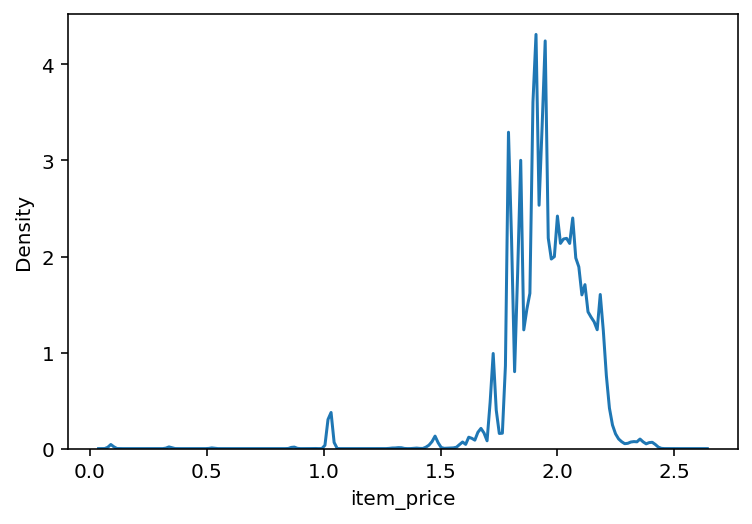

In [311]:
sns.kdeplot(y)
plt.show()

In [308]:
y = np.log1p(y)
y

0          2.067844
1          2.054431
2          2.054431
3          2.133489
4          2.079825
             ...   
2935844    1.902672
2935845    1.902672
2935846    1.925406
2935847    1.902672
2935848    1.902672
Name: item_price, Length: 2935849, dtype: float64

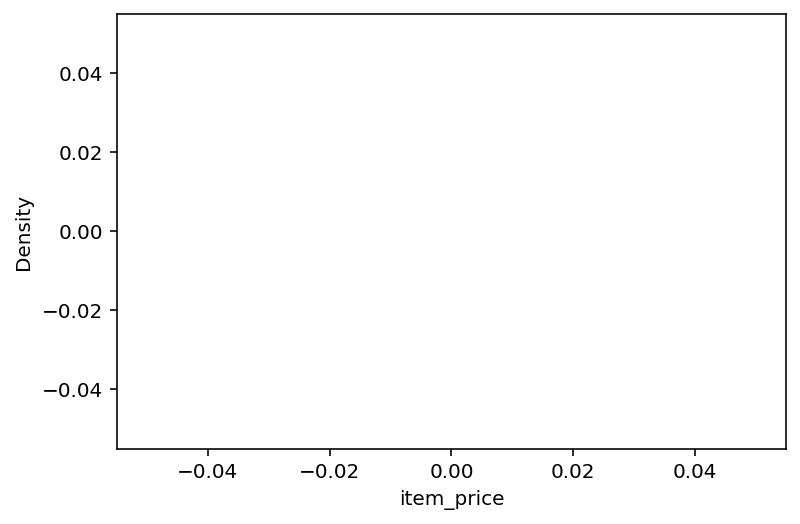

In [297]:
sns.kdeplot(y)
plt.show()

In [298]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_cnt_day    float64
dtypes: float64(1), int64(3), object(1)
memory usage: 112.0+ MB


# RMSE

In [300]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('얍💢')

얍💢


In [301]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢


In [302]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


In [303]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2021        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


In [304]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [305]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

ValueError: could not convert string to float: '18.08.2013'

In [216]:
# E9-10참조  
# RMSE 계산
y = data['item_cnt_day']

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

In [ ]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

In [ ]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

In [ ]:
gboost.__class__.__name__

In [ ]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

In [ ]:
df ={}

def get_scores(models, train, y):
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
    return score_df 

get_scores(models, train, y)

In [112]:
# 13_jan
tt_cnt_jan = num_item_cnt[num_item_cnt['date_block_num'].isin([0])]
tt_cnt_jan

,date_block_num,item_id,item_cnt_day
0,0,22154,1.0
1,0,2552,1.0
2,0,2552,-1.0
3,0,2554,1.0
4,0,2555,1.0
...,...,...,...
115685,0,32,1.0
115686,0,32,1.0
115687,0,35,2.0
115688,0,621,1.0


In [113]:
tt_cnt_jan = tt_cnt_jan.values
tt_cnt_jan

array([[ 0.0000e+00,  2.2154e+04,  1.0000e+00],
       [ 0.0000e+00,  2.5520e+03,  1.0000e+00],
       [ 0.0000e+00,  2.5520e+03, -1.0000e+00],
       ...,
       [ 0.0000e+00,  3.5000e+01,  2.0000e+00],
       [ 0.0000e+00,  6.2100e+02,  1.0000e+00],
       [ 0.0000e+00,  3.2000e+01,  1.0000e+00]])

In [114]:
tt_cnt_jan = tt_cnt_jan[:, 2]
tt_cnt_jan

array([ 1.,  1., -1., ...,  2.,  1.,  1.])

In [116]:
tt_cnt_jan = list(tt_cnt_jan)
sum(tt_cnt_jan)

131479.0

In [117]:
# 13_feb
tt_cnt_feb = num_item_cnt[num_item_cnt['date_block_num'].isin([1])]

tt_cnt_feb = tt_cnt_feb.values

tt_cnt_feb = tt_cnt_feb[:, 2] 

sum(tt_cnt_feb)

128090.0

In [118]:
# 13_mar
tt_cnt_mar = num_item_cnt[num_item_cnt['date_block_num'].isin([2])]

tt_cnt_mar = tt_cnt_mar.values

tt_cnt_mar = tt_cnt_mar[:, 2] 

sum(tt_cnt_mar)

147142.0

In [104]:
# 13년도 판매
tt_cnt = num_item_cnt[num_item_cnt['date_block_num'].isin([0,1,2,3,4,5,6,7,8,9,10,11])]
tt_cnt

,date,date_block_num,item_id,item_cnt_day
0,02.01.2013,0,22154,1.0
1,03.01.2013,0,2552,1.0
2,05.01.2013,0,2552,-1.0
3,06.01.2013,0,2554,1.0
4,15.01.2013,0,2555,1.0
...,...,...,...,...
1267557,06.12.2013,11,5671,1.0
1267558,01.12.2013,11,5671,3.0
1267559,26.12.2013,11,5669,2.0
1267560,25.12.2013,11,5669,1.0


In [102]:
tt_cnt['date'] = pd.to_datetime(tt_cnt["date"])
tt_cnt

,date,date_block_num,item_id,item_cnt_day
0,2013-02-01,0,22154,1.0
1,2013-03-01,0,2552,1.0
2,2013-05-01,0,2552,-1.0
3,2013-06-01,0,2554,1.0
4,2013-01-15,0,2555,1.0
...,...,...,...,...
1267557,2013-06-12,11,5671,1.0
1267558,2013-01-12,11,5671,3.0
1267559,2013-12-26,11,5669,2.0
1267560,2013-12-25,11,5669,1.0


In [103]:
# tt_cnt = tt_cnt.sort_values(by = ['date_block_num'])
# tt_cnt

In [105]:
tt_items = tt_cnt.groupby(['item_id'])['item_cnt_day'].sum().sort_values(ascending=False)
tt_items

item_id
20949    63748.0
2808     12214.0
3732     11981.0
3734      7649.0
16787     6430.0
          ...   
4591         0.0
11871       -1.0
18062       -1.0
13474       -1.0
1590       -11.0
Name: item_cnt_day, Length: 14971, dtype: float64

In [106]:
tt_items.describe()

count    14971.000000
mean       104.384009
std        607.878383
min        -11.000000
25%          5.000000
50%         24.000000
75%         79.000000
max      63748.000000
Name: item_cnt_day, dtype: float64

In [107]:
type(tt_items)

pandas.core.series.Series

In [108]:
# series -> dataframe
tt_items = tt_items.to_frame()
tt_items

,item_cnt_day
item_id,
20949,63748.0
2808,12214.0
3732,11981.0
3734,7649.0
16787,6430.0
...,...
4591,0.0
11871,-1.0
18062,-1.0


In [91]:
print(tt_items[['item_cnt_day']])

         item_cnt_day
item_id              
20949         63748.0
2808          12214.0
3732          11981.0
3734           7649.0
16787          6430.0
...               ...
4591              0.0
11871            -1.0
18062            -1.0
13474            -1.0
1590            -11.0

[14971 rows x 1 columns]
